In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [26]:
base_path = r".\Quantitative Research Intern data"

tickers = ["CRWV", "FROG", "SOUN"]

# Dictionary to store DataFrames for each ticker
data = {}

for ticker in tickers:
    folder_path = os.path.join(base_path, ticker)
    csv_files = glob.glob(os.path.join(folder_path, f"{ticker}_2025*.csv"))
    
    # Load and concatenate all CSVs for the current ticker
    df_list = [pd.read_csv(file) for file in csv_files]
    data[ticker] = pd.concat(df_list, ignore_index=True)
    
    print(f"Loaded {len(csv_files)} files for {ticker}, total rows: {len(data[ticker])}")


data["CRWV"].head(10)

Loaded 21 files for CRWV, total rows: 1882484
Loaded 21 files for FROG, total rows: 589053
Loaded 21 files for SOUN, total rows: 5505097


,ts_event,ts_event.1,rtype,publisher_id,instrument_id,action,side,depth,price,size,...,ask_sz_08,bid_ct_08,ask_ct_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,bid_ct_09,ask_ct_09,symbol
0,2025-04-03 13:30:00.012155347+00:00,2025-04-03 13:30:00.012155347+00:00,10,2,20613,T,B,0,55.40,99,...,4,1,1,54.55,56.70,100,10,1,1,CRWV
1,2025-04-03 13:30:00.012155347+00:00,2025-04-03 13:30:00.012155347+00:00,10,2,20613,T,B,0,55.40,100,...,4,1,1,54.55,56.70,100,10,1,1,CRWV
2,2025-04-03 13:30:00.012155347+00:00,2025-04-03 13:30:00.012155347+00:00,10,2,20613,T,N,0,55.40,551,...,10,1,1,54.55,56.91,100,100,1,1,CRWV
3,2025-04-03 13:30:00.012344442+00:00,2025-04-03 13:30:00.012344442+00:00,10,2,20613,A,A,0,55.40,100,...,4,1,1,54.55,56.70,100,10,1,1,CRWV
4,2025-04-03 13:30:00.012800457+00:00,2025-04-03 13:30:00.012800457+00:00,10,2,20613,A,B,0,55.39,100,...,4,1,1,54.57,56.70,400,10,1,1,CRWV
5,2025-04-03 13:30:00.013396841+00:00,2025-04-03 13:30:00.013396841+00:00,10,2,20613,C,B,0,53.68,100,...,4,1,1,54.55,56.70,100,10,1,1,CRWV
6,2025-04-03 13:30:00.120353811+00:00,2025-04-03 13:30:00.120353811+00:00,10,2,20613,A,B,0,55.28,100,...,4,1,1,54.57,56.70,400,10,1,1,CRWV
7,2025-04-03 13:30:00.121870648+00:00,2025-04-03 13:30:00.121870648+00:00,10,2,20613,T,B,0,55.40,100,...,4,1,1,54.57,56.70,400,10,1,1,CRWV
8,2025-04-03 13:30:00.121870648+00:00,2025-04-03 13:30:00.121870648+00:00,10,2,20613,C,A,0,55.40,100,...,10,1,1,54.57,56.83,400,100,1,1,CRWV
9,2025-04-03 13:30:00.121873007+00:00,2025-04-03 13:30:00.121873007+00:00,10,2,20613,T,N,0,55.40,100,...,10,1,1,54.57,56.83,400,100,1,1,CRWV


### MBP-10 is a Level 2 (L2) order book data feed that includes only the best 10 bid and ask prices, their sizes, and order counts. This is a standard practice because: 

- Most trades occur near the top of the book (best bid/ask prices).

- Data beyond 10 levels is often not critical for short-term trading strategies and would create large data overhead.

In [30]:
# Creating an Order Book snapshot
def get_order_book_snapshot_for_tickers(data_dict, index=0):

    snapshots = {}
    for ticker, df in data_dict.items():
        row = df.iloc[index]
        ask_prices = [row[f'ask_px_{i:02}'] for i in range(10)]
        bid_prices = [row[f'bid_px_{i:02}'] for i in range(10)]
        ask_sizes = [row[f'ask_sz_{i:02}'] for i in range(10)]
        bid_sizes = [row[f'bid_sz_{i:02}'] for i in range(10)]
        
        snapshots[ticker] = pd.DataFrame({
            'ask_px': ask_prices,
            'ask_sz': ask_sizes,
            'bid_px': bid_prices,
            'bid_sz': bid_sizes
        })
    return snapshots

# Example usage:
order_books = get_order_book_snapshot_for_tickers(data, index=0)

for ticker, _ in data.items():
    print(f"Order Book for {ticker}:")
    print(order_books[ticker])
    print()



Order Book for CRWV:
   ask_px  ask_sz  bid_px  bid_sz
0   55.40     199   55.10       1
1   55.46      10   55.06    1667
2   55.47     100   55.03     200
3   55.50     100   55.00      80
4   55.93      50   54.98      20
5   56.00     200   54.80      10
6   56.24       3   54.78     100
7   56.45       5   54.66       1
8   56.66       4   54.57     400
9   56.70      10   54.55     100

Order Book for FROG:
   ask_px  ask_sz  bid_px  bid_sz
0   32.00     200   30.10      50
1   32.64     100   30.00     147
2   32.66     200   29.99       1
3   32.82     800   29.76     200
4   33.15      10   29.23     800
5   33.18       5   29.10     100
6   33.28     200   29.00      20
7   33.30     800   28.97     100
8   33.85       4   28.96     800
9   33.92     100   28.49     100

Order Book for SOUN:
   ask_px  ask_sz  bid_px  bid_sz
0    7.91     164    7.89     112
1    7.92       4    7.88     132
2    7.94      30    7.87     168
3    7.95      79    7.86     651
4    7.99      29

### Function to calculate the price impact of a trade or slippage

In [32]:
#Calculate temporary impact (slippage) for buying x shares from ask side.
def calculate_slippage(order_book, x):
    """
    Calculate temporary impact (slippage) for buying x shares from ask side.
    """
    ask_prices = order_book['ask_px'].values
    ask_sizes = order_book['ask_sz'].values

    shares_remaining = x
    cost = 0
    for price, size in zip(ask_prices, ask_sizes):
        shares_to_buy = min(size, shares_remaining)
        cost += shares_to_buy * price
        shares_remaining -= shares_to_buy
        if shares_remaining <= 0:
            break

    if shares_remaining > 0:
        # Not enough liquidity in the book to buy x shares
        cost += shares_remaining * ask_prices[-1]  # assume last level price

    avg_price = cost / x
    mid_price = (order_book['ask_px'].iloc[0] + order_book['bid_px'].iloc[0]) / 2
    slippage = avg_price - mid_price
    return slippage


### Simulating the Slippage

In [33]:
# Simulating the slippage 
def simulate_all_tickers(order_books, max_x=30000, step=500):
    results = {}
    for ticker, df in order_books.items():
        x_values = list(range(step, max_x + step, step))
        g_values = [calculate_slippage(df, x) for x in x_values]
        results[ticker] = (x_values, g_values)
    return results

results = simulate_all_tickers(order_books)


### Fitting and plotting the result of the simulation of the quadratic model.

Fitted Model: g_t(x) = 0.9531 + 0.0001x + -0.000000x²


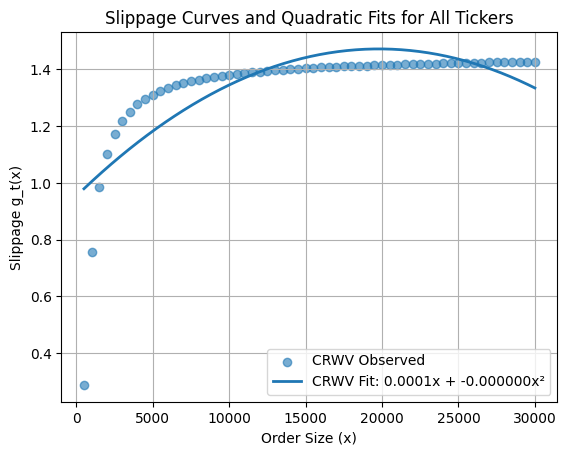

Fitted Model: g_t(x) = 1.7743 + 0.0001x + -0.000000x²


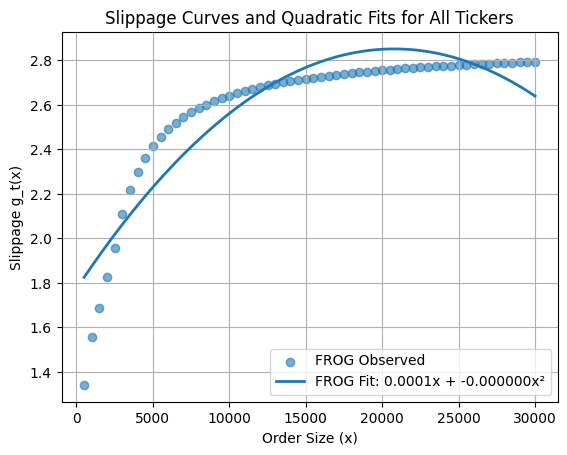

Fitted Model: g_t(x) = 0.1107 + 0.0000x + -0.000000x²


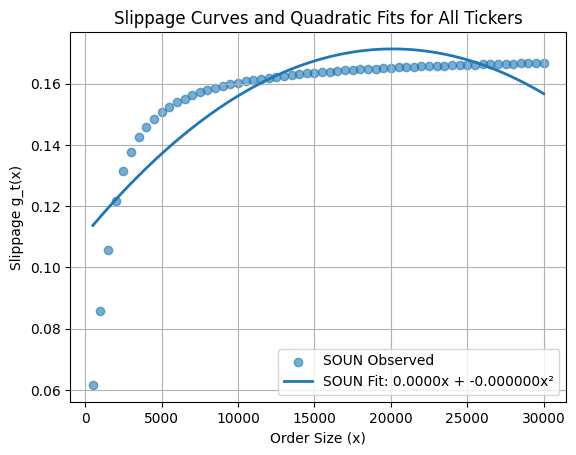

In [34]:
# Fitting the Quadratic Model to Simulated Slippage Curves
def fit_quadratic(x, g):
    x = np.array(x_values)
    g = np.array(g_values)

    # Create matrix with columns [1, x, x^2]
    A = np.vstack([np.ones(len(x)), x, x**2]).T
    c, a, b = np.linalg.lstsq(A, g, rcond=None)[0]
    return c, a, b

for t in tickers:   
    x_values, g_values = simulate_slippage(order_books[t])
    c, a, b = fit_quadratic(x_values, g_values)
    print(f"Fitted Model: g_t(x) = {c:.4f} + {a:.4f}x + {b:.6f}x²")
    x_fit = np.linspace(min(x_values), max(x_values), 200)
    g_fit = c + a * x_fit + b * x_fit**2
        
    # Plot
    plt.scatter(x_values, g_values, label=f"{t} Observed", alpha=0.6)
    plt.plot(x_fit, g_fit, linewidth=2, label=f"{t} Fit: {a:.4f}x + {b:.6f}x²")
    plt.title("Slippage Curves and Quadratic Fits for All Tickers")
    plt.xlabel("Order Size (x)")
    plt.ylabel("Slippage g_t(x)")
    plt.grid(True)
    plt.legend()
    plt.show()

### Fitting and plotting the result of the simulation of the quadratic model.

The reason I added the **y-intercept** is:
1. Real-world slippage data rarely passes through (0,0).
   
2. Forcing the curve through zero (no intercept) can distort `a` and `b`.
  
3. Adding `c` gives the model flexibility:** The constant term absorbs the baseline bias , so the quadratic terms (a and b) focus only on modeling the growth of slippage with order size.

Hence the experiment is a success even with real world data.